# Single time step prediction
## — with single input 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as L

from darts.datasets import EnergyDataset
from darts.dataprocessing.transformers import MissingValuesFiller
import numpy as np

from ontime.module import preprocessing

In [30]:
input_length = 10
target_length = 1
nb_neurons_hidden_layer = 30
shift = 2
num_epochs = 500

---
## Load data

In [2]:
energy_ts = EnergyDataset().load()
energy_ts = energy_ts.astype(np.float32)
single_ts = energy_ts.univariate_component(0)

---
## Preprocessing

In [11]:
# Fill missing values
transformer = MissingValuesFiller()
single_ts = transformer.transform(single_ts)

# Normalize
single_ts = preprocessing.common.normalize(single_ts)

# Train test split
train, test = preprocessing.common.train_test_split(single_ts, train_split=0.8)

# Split in vectors of length n
train_list = preprocessing.common.split_by_length(train, length=input_length + target_length, shift=shift)
test_list = preprocessing.common.split_by_length(test, length=input_length + target_length, shift=shift)

# Split each vector in input and target
X_train, y_train = preprocessing.common.split_inputs_from_targets(train_list, input_length=input_length,
                                                                  target_length=target_length)
X_test, y_test = preprocessing.common.split_inputs_from_targets(test_list, input_length=input_length,
                                                                target_length=target_length)

# Convert to Numpy
X_train = preprocessing.common.timeseries_list_to_numpy(X_train)
y_train = preprocessing.common.timeseries_list_to_numpy(y_train)
X_test = preprocessing.common.timeseries_list_to_numpy(X_test)
y_test = preprocessing.common.timeseries_list_to_numpy(y_test)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14020, 10, 1)
(14020, 1, 1)
(3501, 10, 1)
(3501, 1, 1)


---
## Modelling

In [43]:
model = nn.Sequential(
    nn.Flatten(),    
    nn.Linear(input_length, nb_neurons_hidden_layer),
    nn.ReLU(),
    nn.Linear(nb_neurons_hidden_layer, target_length)
)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Convert X_train and y_train to PyTorch tensors if not already
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)


In [44]:

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

C:\Users\vince\AppData\Local\pypoetry\Cache\virtualenvs\ontime-FclhqCOu-py3.11\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([14020, 1, 1])) that is different to the input size (torch.Size([14020, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/500], Loss: 0.0337
Epoch [200/500], Loss: 0.0315
Epoch [300/500], Loss: 0.0293
Epoch [400/500], Loss: 0.0272
Epoch [500/500], Loss: 0.0254


### Evaluate 

In [45]:
# Convert X_val and y_val to PyTorch tensors if not already
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Set the model to evaluation mode
model.eval()

# Forward pass on the validation set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f'Validation Loss: {test_loss.item():.4f}')


Validation Loss: 0.0098


C:\Users\vince\AppData\Local\pypoetry\Cache\virtualenvs\ontime-FclhqCOu-py3.11\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3501, 1, 1])) that is different to the input size (torch.Size([3501, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


---
## Predict

In [46]:
# Forward pass on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Convert the tensor results back to a NumPy array
predicted_values = test_outputs.numpy()

predicted_values

array([[0.5681623 ],
       [0.5740853 ],
       [0.56192374],
       ...,
       [0.602169  ],
       [0.60263485],
       [0.60241795]], dtype=float32)

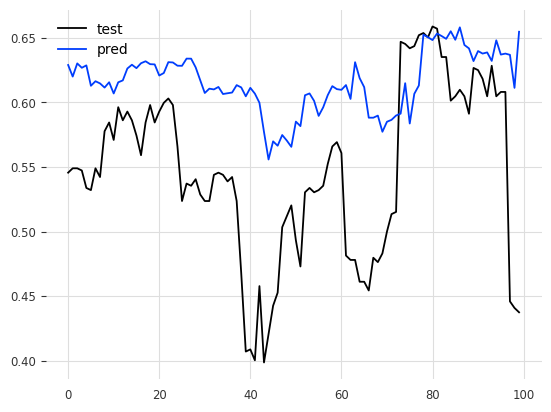

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

start = 500
width = 100

fig, ax = plt.subplots()
pd.DataFrame(y_test.squeeze()[start:start + width]).plot(ax=ax)
pd.DataFrame(predicted_values.squeeze()[start:start + width]).plot(ax=ax)
ax.legend(['test', 'pred']);